# Ejercicio con kNNs

Primero, descargamos un dataset sobre el que vamos a trabajar en nuestro ejercicio en un subdirectorio `data` de nuestro directorio de trabajo:

In [1]:
!curl -o data/diabetes.csv https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (60) SSL certificate problem: unable to get local issuer certificate
More details here: https://curl.haxx.se/docs/sslcerts.html

curl failed to verify the legitimacy of the server and therefore could not
establish a secure connection to it. To learn more about this situation and
how to fix it, please visit the web page mentioned above.


A continuación, cargamos los módulos que utilizaremos en el ejercicio:

In [13]:
# Nuestros sospechosos habituales
import pandas as pd
import numpy as np
import matplotlib

# También, como siempre, nos apoyamos en Scikit-Learn para hacer el split en training y test
from sklearn.model_selection import train_test_split
# Usaremos el preprocesador StandardScaler para no tener sesgos en los datos
# de entrada
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
# Importamos herramientas para evaluar el modelo. F1 es la media
# armónica de precision y recall
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

%matplotlib inline
from preamble import *

/home/dsc/anaconda3/envs/ks-sl/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Ahora es el turno de cargar el dataset en un Pandas dataframe y de investigar un poco qué es lo que tenemos en términos de número de muestras y de features. Apoyaos en la documentación pública de Pandas para investigar cómo cargar un dataset (lo veremos en clase de todas formas). Escribid el código en los placeholders marcados con `#tu código aquí#`:

In [2]:
# Leemos el CSV que hemos descargado con la ayuda de los métos que nos ofrecen
# los dataframes de Pandas
dataset = pd.read_csv('data/diabetes.csv')

# Vemos cuántas muestras tiene nuestro dataset
print(dataset.shape)

# Miramos también qué pinta tiene el dataset desde el
# punto de vista de características y etiquetas, usando las capacidades de
# nuevo de los dataframes de Pandas
dataset.describe()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Trata de investigar si hay columnas del dataset que contienen valores que son nulos y que no tienen sentido. Como ejemplo, un grosor de piel de valor cero no tiene mucho sentido:

In [28]:
# Escribe código para filtrar los valores nulos de 1 columna del DataFrame y visualizarlos,
# deberías poder hacerlo en 1 línea
dataset[dataset['SkinThickness']==0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
9,8,125,96,0,0,0.0,0.232,54,1
10,4,110,92,0,0,37.6,0.191,30,0
...,...,...,...,...,...,...,...,...,...
757,0,123,72,0,0,36.3,0.258,52,1
758,1,106,76,0,0,37.5,0.197,26,0
759,6,190,92,0,0,35.5,0.278,66,1
762,9,89,62,0,0,22.5,0.142,33,0


In [29]:
dataset[dataset['BloodPressure']==0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115,0,0,0,35.3,0.134,29,0
15,7,100,0,0,0,30.0,0.484,32,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
78,0,131,0,0,0,43.2,0.270,26,1
81,2,74,0,0,0,0.0,0.102,22,0
172,2,87,0,23,0,28.9,0.773,25,0
193,11,135,0,0,0,52.3,0.578,40,1
222,7,119,0,0,0,25.2,0.209,37,0
261,3,141,0,0,0,30.0,0.761,27,1


Ahora, para la columna correspondiente a la feature que has elegido explorar (por ejemplo, skinThickness), calcula la media de los valores:

In [32]:
# Calcula la media de los valores de 1 columna de tu DataFrame
dataset['SkinThickness'].mean()

20.536458333333332

In [33]:
dataset['BloodPressure'].mean()

69.10546875

Lo que vamos a hacer ahora es sustituir los valores nulos por la media de todos los valores de la columna, con el objetivo de poder seguir contando con las muestras que los tienen. Como pista, debes hacer esa operación para todas estas columnas en el DataFrame: 'Glucose','BloodPressure','SkinThickness','BMI','Insulin'. Lo mejor es que escribas código que itere sobre esas columnas para realizar la operación:

In [3]:
# Almacena las columnas a alterar en una lista de Python
col_ch = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Itera sobre cada elemento de la lista, calculando la media y posteriormente sustituyendo 
#los ceros por el valor calculado de la media
for col in col_ch:
    col_mean = dataset[col].mean()
    dataset.loc[dataset[col]==0, [col]] = col_mean

In [4]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Antes de comenzar con el proceso de entrenamiento, como siempre, partimos el dataset en training y test. Elige un 20% del dataset para el conjunto de testing, dejando el 80% restante para el entrenamiento:

In [5]:
X = dataset.iloc[:, :7]
y = dataset.iloc[:, 8]

In [66]:
type(y)

pandas.core.series.Series

In [32]:
# Recuerda que la columna nueve (índice 8) es la que tiene
# nuestras etiquetas, y que el resto contiene las features.
X = dataset.iloc[:, :7]
y = dataset.iloc[:, 8]
# Haz el split, selecciona un 20% del dataset original como datos de test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Lo siguiente será escalar los datos, ésta es una técnica de ingeniería de características que será necesaria para poder calcular distancias correctamente con KNNs (veremos más sobre esto en clase):

In [33]:
# Ahora escalamos los datos, de manera que todos los rangos van desde -1 hasta 1.
sc_X = StandardScaler()
# Hacemos training y transformación conjunta sobre el training set
X_train = sc_X.fit_transform(X_train)
# Tenemos que asegurarnos de que el testing set también está transformado
X_test = sc_X.transform(X_test)

Una buena estimación del número de vecinos suele ser la raíz cuadrada del número de características. Usa este número como tu configuración inicial de `n_neighbors` y procede crear y entrenar un kNN:

In [30]:
# Define el modelo, inicializando kNN con los datos seleccionados 
import math
n_neighbors = round(math.sqrt(8))
cls = KNeighborsClassifier(n_neighbors=n_neighbors)
# Entrena el modelo
cls.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Finalmente, evalua el modelo sobre el dataset de test, y muestra la precisión obtenida:

In [31]:
#tu código aquí#
cls.score(X_test, y_test)

0.7552083333333334

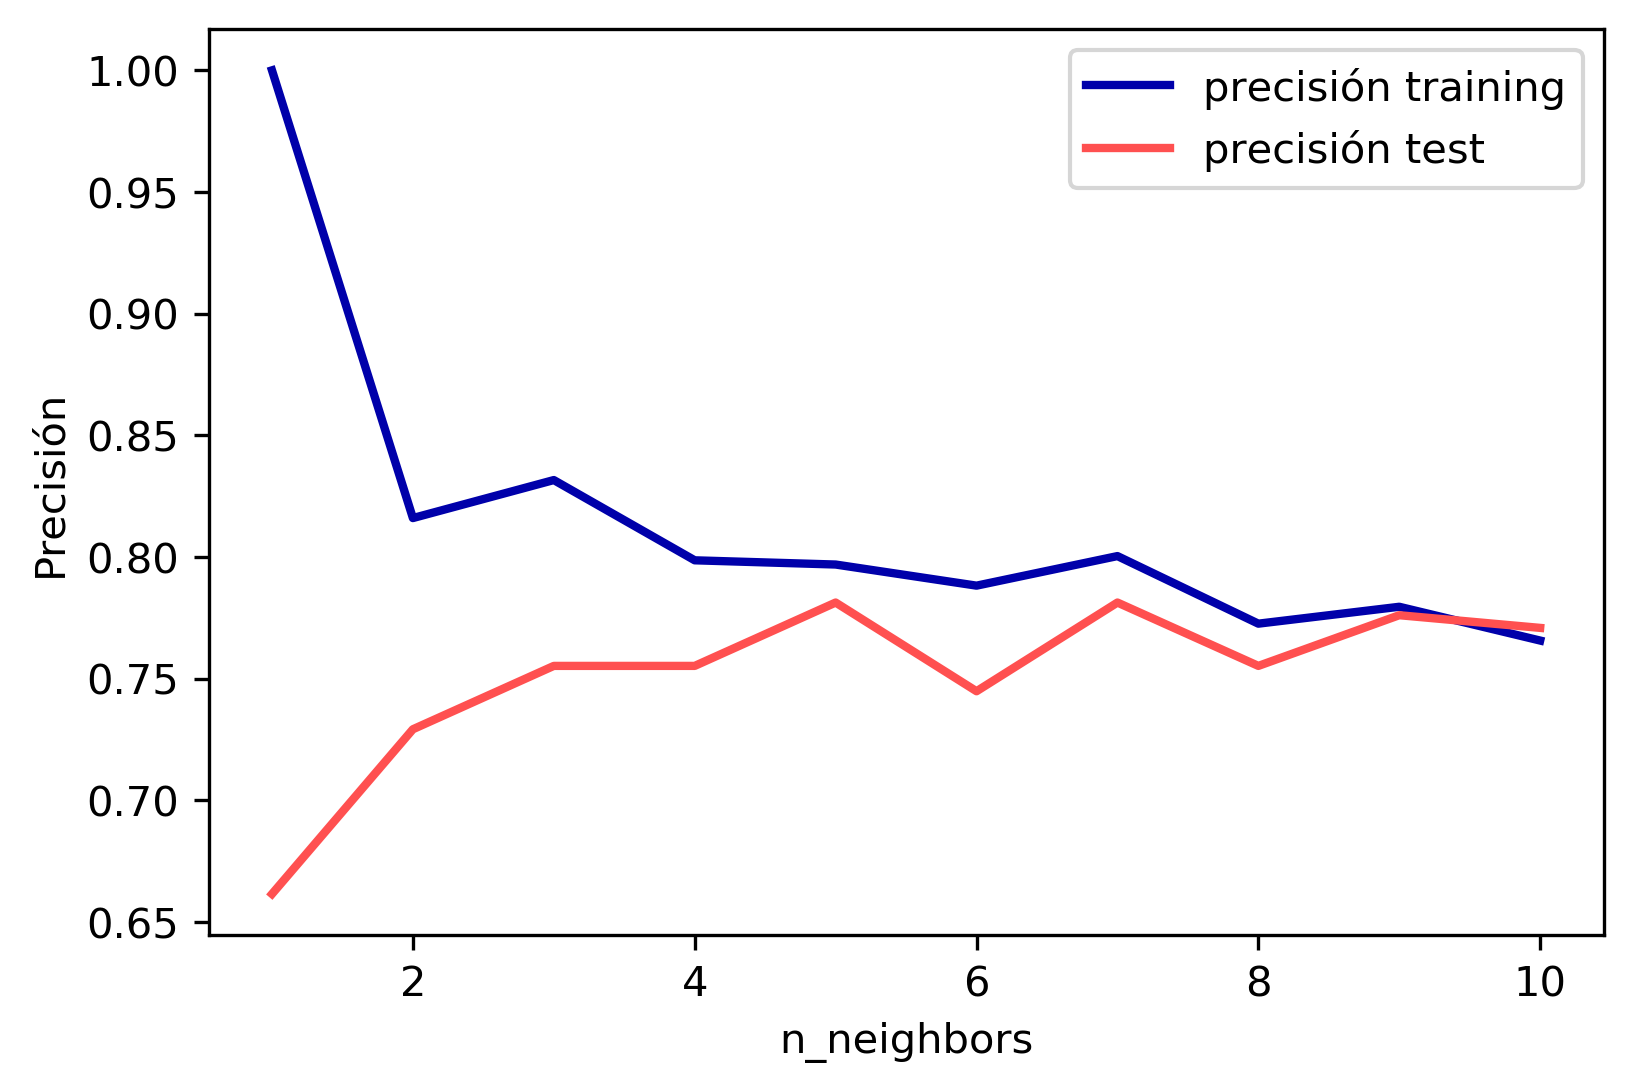

In [34]:
training_accuracy = []
test_accuracy = []
# Probamos n_neighbors de 1 a 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # Construimos el modelo
    cls = KNeighborsClassifier(n_neighbors=n_neighbors)
    cls.fit(X_train, y_train)
    # Guardamos la precisión del training set
    training_accuracy.append(cls.score(X_train, y_train))
    # Guardamos la precisión de testing set (generalización)
    test_accuracy.append(cls.score(X_test, y_test))
    
plt.plot(neighbors_settings,
         training_accuracy, label="precisión training")
plt.plot(neighbors_settings, test_accuracy, label="precisión test")
plt.ylabel("Precisión")
plt.xlabel("n_neighbors")
plt.legend()

In [35]:
test_accuracy

[0.6614583333333334,
 0.7291666666666666,
 0.7552083333333334,
 0.7552083333333334,
 0.78125,
 0.7447916666666666,
 0.78125,
 0.7552083333333334,
 0.7760416666666666,
 0.7708333333333334]

In [36]:
test_accuracy[4] == test_accuracy[6]

True

In [37]:
training_accuracy[4] < training_accuracy[6]

True

In [38]:
cls = KNeighborsClassifier(n_neighbors=5)
# Entrena el modelo
cls.fit(X_train, y_train)
cls.score(X_test, y_test)

0.78125